# Load pretrain

In [1]:
from pre_model import unet, unet3plus, unet_xception, ducknet, segnet

# Import Library

In [2]:
import numpy as np
import tensorflow as tf

import keras.backend as K
from keras.layers import Flatten
from keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Metrics setup

In [4]:
def dice_score(mask_gt, mask_pred):
    volume_sum = mask_gt.sum() + mask_pred.sum()
    if volume_sum == 0:
        return np.NaN
    volume_intersect = (mask_gt & mask_pred).sum()
    return 2*volume_intersect / volume_sum

def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)


def jacard_coef(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1)

def sensitivity(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Load data

In [5]:
import os

image_path = "/content/drive/MyDrive/polyp_segmentation/kvasir_dataset/images/"
mask_path = "/content/drive/MyDrive/polyp_segmentation/kvasir_dataset/masks/"
pimage_path = "/content/drive/MyDrive/polyp_segmentation/kvasir_dataset/converted_images/"

test_ids = []

with open("/content/drive/MyDrive/polyp_segmentation/kvasir_dataset/test.txt", "r") as file:
    for line in file:
        test_ids.append(line.strip())

# Load models

In [6]:
# model pretrained with data no prep
omodel_path = "/content/drive/MyDrive/polyp_segmentation/pretrained_model/omodel/"
osegnet_path = omodel_path + 'segnet.weights.h5'
ounet3p_path = omodel_path + 'unet3plus.weights.h5'
oducknet_path = omodel_path + 'duck_net.weights.h5'
ounetx_path = omodel_path + 'unet_xcept.weights.h5'
ounet_path = omodel_path + 'unet.weights.h5'

# model pretrained
pmodel_path = "/content/drive/MyDrive/polyp_segmentation/pretrained_model/pmodel/"
psegnet_path = pmodel_path + 'segnet.weights.h5'
punet3p_path = pmodel_path + 'unet3plus.weights.h5'
pducknet_path = pmodel_path + 'duck_net.weights.h5'
punetx_path = pmodel_path + 'unet_xception.weights.h5'
punet_path = pmodel_path + 'unet.weights.h5'

In [7]:
osegnet_model = segnet((256, 256, 3), 3)
osegnet_model.load_weights(osegnet_path)

ounet3p_model = unet3plus((256, 256, 3), 3)
ounet3p_model.load_weights(ounet3p_path)

oducknet_model = ducknet((256, 256), 3)
oducknet_model.load_weights(oducknet_path)

ounetx_model = unet_xception((256, 256), 3)
ounetx_model.load_weights(ounetx_path)

ounet_model = unet((256, 256), 3)
ounet_model.load_weights(ounet_path)

94765736/94765736 [==============================] - 1s 0us/step


In [8]:
psegnet_model = segnet((256, 256, 3), 3)
psegnet_model.load_weights(psegnet_path)

punet3p_model = unet3plus((256, 256, 3), 3)
punet3p_model.load_weights(punet3p_path)

pducknet_model = ducknet((256, 256), 3)
pducknet_model.load_weights(pducknet_path)

punetx_model = unet_xception((256, 256), 3)
punetx_model.load_weights(punetx_path)

punet_model = unet((256, 256), 3)
punet_model.load_weights(punet_path)

# Evaluate

In [ ]:
import cv2

def generate_data_pred(filelist, img_path, mask_path, gen_type = "train"):
    while True:
        for i in filelist:
          original_img = cv2.imread(img_path + i, cv2.IMREAD_COLOR)
          X_train = cv2.resize(original_img, (256,256), interpolation=cv2.INTER_LINEAR)

          original_mask = cv2.imread(mask_path + i, cv2.IMREAD_COLOR)
          _,original_mask = cv2.threshold(original_mask, 127, 255, cv2.THRESH_BINARY)

          y_mask = cv2.resize(original_mask, (256,256), interpolation=cv2.IMREAD_GRAYSCALE)
          _,y_mask = cv2.threshold(y_mask, 127, 255, cv2.THRESH_BINARY)
          y_mask = (y_mask/255).astype(int)
          yield original_img, original_mask, X_train, y_mask

In [ ]:
from sklearn.metrics import jaccard_score

def evaluate(model, image_path, test_ids):
    test_gen = generate_data_pred(test_ids, image_path, mask_path, gen_type = "test")

    dice_list = []
    iou_list = []
    sens_list = []
    spec_list = []

    testsize = len(test_ids)

    for i in range(testsize):
        _, _, X, y_true = next(test_gen)

        y_pred = model.predict(np.expand_dims(X, 0), verbose=0)
        _, y_pred_thr = cv2.threshold(y_pred[0, :, :, 0]*255, 127, 255, cv2.THRESH_BINARY)

        y_pred = (y_pred_thr/255).astype(int)

        dice_sc = dice_score(y_true[:,:,0], y_pred)
        iou_sc = jaccard_score(y_true[:,:,0], y_pred, average="micro")
        sens_sc = sensitivity(y_true[:,:,0], y_pred)
        spec_sc = specificity(y_true[:,:,0], y_pred)

        dice_list.append(dice_sc)
        iou_list.append(iou_sc)
        sens_list.append(sens_sc)
        spec_list.append(spec_sc)

    # print("DICE:", np.mean(dice_list))
    # print("IOU:", np.mean(iou_list))
    # print("SENS:", np.mean(sens_list))
    # print("SPEC:", np.mean(spec_list))

    return dice_list, iou_list, sens_list, spec_list

## SEGNET

In [ ]:
dice_list, iou_list, sens_list, spec_list = evaluate(osegnet_model, image_path, test_ids)

# dice_list, iou_list, sens_list, spec_list
print("DICE:", np.mean(dice_list))
print("IOU:", np.mean(iou_list))
print("SENS:", np.mean(sens_list))
print("SPEC:", np.mean(spec_list))


DICE: 0.5510476832156952
IOU: 0.4170818363641046
SENS: 0.66612375
SPEC: 0.9216271


In [ ]:
dice_list, iou_list, sens_list, spec_list = evaluate(psegnet_model, pimage_path, test_ids)

# dice_list, iou_list, sens_list, spec_list
print("DICE:", np.mean(dice_list))
print("IOU:", np.mean(iou_list))
print("SENS:", np.mean(sens_list))
print("SPEC:", np.mean(spec_list))

DICE: 0.6284639515793726
IOU: 0.5031782940318953
SENS: 0.69476813
SPEC: 0.950813


## UNET XCEPTION

In [ ]:
dice_list, iou_list, sens_list, spec_list = evaluate(ounetx_model, image_path, test_ids)

# dice_list, iou_list, sens_list, spec_list
print("DICE:", np.mean(dice_list))
print("IOU:", np.mean(iou_list))
print("SENS:", np.mean(sens_list))
print("SPEC:", np.mean(spec_list))

DICE: 0.7499572693709488
IOU: 0.6518837526861171
SENS: 0.770667
SPEC: 0.97621644


In [ ]:
dice_list, iou_list, sens_list, spec_list = evaluate(punetx_model, pimage_path, test_ids)

# dice_list, iou_list, sens_list, spec_list
print("DICE:", np.mean(dice_list))
print("IOU:", np.mean(iou_list))
print("SENS:", np.mean(sens_list))
print("SPEC:", np.mean(spec_list))

DICE: 0.5985786334740394
IOU: 0.4870961662443024
SENS: 0.65400314
SPEC: 0.96093214


## DUCKNET

In [ ]:
dice_list, iou_list, sens_list, spec_list = evaluate(oducknet_model, image_path, test_ids)

# dice_list, iou_list, sens_list, spec_list
print("DICE:", np.mean(dice_list))
print("IOU:", np.mean(iou_list))
print("SENS:", np.mean(sens_list))
print("SPEC:", np.mean(spec_list))

DICE: 0.16642227955778796
IOU: 0.1262273255725993
SENS: 0.13827059
SPEC: 0.9959855


In [ ]:
dice_list, iou_list, sens_list, spec_list = evaluate(pducknet_model, pimage_path, test_ids)

print("DICE:", np.mean(dice_list))
print("IOU:", np.mean(iou_list))
print("SENS:", np.mean(sens_list))
print("SPEC:", np.mean(spec_list))

DICE: 0.749858922049216
IOU: 0.6598983459663755
SENS: 0.75774467
SPEC: 0.97894174


## UNET 3+

In [ ]:
dice_list, iou_list, sens_list, spec_list = evaluate(ounet3p_model, image_path, test_ids)

print("DICE:", np.mean(dice_list))
print("IOU:", np.mean(iou_list))
print("SENS:", np.mean(sens_list))
print("SPEC:", np.mean(spec_list))

DICE: 0.821146686801924
IOU: 0.7443928875818887
SENS: 0.86298233
SPEC: 0.9733835


In [ ]:
dice_list, iou_list, sens_list, spec_list = evaluate(punet3p_model, pimage_path, test_ids)

print("DICE:", np.mean(dice_list))
print("IOU:", np.mean(iou_list))
print("SENS:", np.mean(sens_list))
print("SPEC:", np.mean(spec_list))

DICE: 0.8648464904280686
IOU: 0.8023383477739364
SENS: 0.8776228
SPEC: 0.9855096


## UNET

In [ ]:
dice_list, iou_list, sens_list, spec_list = evaluate(ounet_model, image_path, test_ids)

print("DICE:", np.mean(dice_list))
print("IOU:", np.mean(iou_list))
print("SENS:", np.mean(sens_list))
print("SPEC:", np.mean(spec_list))

DICE: 0.43672607040532196
IOU: 0.3136971432394424
SENS: 0.6463507
SPEC: 0.8493023


In [ ]:
dice_list, iou_list, sens_list, spec_list = evaluate(punet_model, pimage_path, test_ids)

print("DICE:", np.mean(dice_list))
print("IOU:", np.mean(iou_list))
print("SENS:", np.mean(sens_list))
print("SPEC:", np.mean(spec_list))

DICE: 0.42903730725873707
IOU: 0.30750344025548165
SENS: 0.68799025
SPEC: 0.8149575


# Predict and compare mask

## Func

In [9]:
import matplotlib.pyplot as plt

def predict_mask(model, X, process = True):
    if process == False:
      X = cv2.resize(X, (256,256), interpolation=cv2.INTER_LINEAR)
    y_pred = model.predict(np.expand_dims(X, 0), verbose=0)
    _, mask = cv2.threshold(y_pred[0, :, :, 0]*255, 127, 255, cv2.THRESH_BINARY)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    return mask.astype(int)

In [10]:
column_titles1 = ['ORIGINAL IMAGES', 'PROCESSED IMAGES', 'MASKS',
                  'UNET XCEPTION (O)', 'UNET XCEPTION (P)',
                  'UNET (O)', 'UNET (P)']

def plot_mask1(path_list):
  num = len(path_list)
  fig, axes = plt.subplots(len(path_list), 7, figsize=(32, 4*num))

  for i, n in enumerate(path_list):

    X = cv2.imread(pimage_path + test_ids[n])

    # ORIGINAL IMAGES
    ori = cv2.cvtColor(cv2.imread(image_path + test_ids[n]), cv2.COLOR_BGR2RGB)
    ori = cv2.resize(ori, (256,256), interpolation=cv2.INTER_LINEAR)
    axes[i, 0].imshow(ori)

    # PROCESSED IMAGES
    X_rgb = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    axes[i, 1].imshow(X_rgb)

    # MASKS
    ori_mask = cv2.cvtColor(cv2.imread(mask_path + test_ids[n]), cv2.COLOR_BGR2RGB)
    ori_mask = cv2.resize(ori_mask, (256,256), interpolation=cv2.INTER_LINEAR)
    axes[i, 2].imshow(ori_mask)

    # UNET XCEPTION (O)
    omask_unetx = predict_mask(ounetx_model, X, False)
    axes[i, 3].imshow(omask_unetx)

    # UNET XCEPTION (P)
    pmask_unetx = predict_mask(punetx_model, X, True)
    axes[i, 4].imshow(pmask_unetx)

    # UNET (O)
    omask_unet = predict_mask(ounet_model, X, False)
    axes[i, 5].imshow(omask_unet)

    # UNET (P)
    pmask_unet = predict_mask(punet_model, X, True)
    axes[i, 6].imshow(pmask_unet)

    if i == 0:
      for j in range(len(column_titles1)):
        axes[i, j].set_title(column_titles1[j], fontsize=12)

In [11]:
column_titles2 = ['ORIGINAL IMAGES', 'PROCESSED IMAGES', 'MASKS',
                  'DUCKNET (O)', 'DUCKNET (P)',
                  'UNET3+ (O)', 'UNET3+ (P)',
                  'SEGNET (O)', 'SEGNET (P)']

def plot_mask2(path_list):
  num = len(path_list)
  fig, axes = plt.subplots(len(path_list), 9, figsize=(32, 4*num))

  for i, n in enumerate(path_list):

    X = cv2.imread(pimage_path + test_ids[n])

    # ORIGINAL IMAGES
    ori = cv2.cvtColor(cv2.imread(image_path + test_ids[n]), cv2.COLOR_BGR2RGB)
    ori = cv2.resize(ori, (256,256), interpolation=cv2.INTER_LINEAR)
    axes[i, 0].imshow(ori)

    # PROCESSED IMAGES
    X_rgb = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    axes[i, 1].imshow(X_rgb)

    # MASKS
    ori_mask = cv2.cvtColor(cv2.imread(mask_path + test_ids[n]), cv2.COLOR_BGR2RGB)
    ori_mask = cv2.resize(ori_mask, (256,256), interpolation=cv2.INTER_LINEAR)
    axes[i, 2].imshow(ori_mask)

    # DUCKNET (O)
    omask_unetx = predict_mask(ounetx_model, X, False)
    axes[i, 3].imshow(omask_unetx)

    # DUCKNET (P)
    pmask_ducknet = predict_mask(pducknet_model, X, True)
    axes[i, 4].imshow(pmask_ducknet)

    # UNET3+ (O)
    omask_unet3p = predict_mask(ounet3p_model, X, False)
    axes[i, 5].imshow(omask_unet3p)

    # UNET3+ (P)
    pmask_unet3p = predict_mask(punet3p_model, X, True)
    axes[i, 6].imshow(pmask_unet3p)

    # SEGNET (O)
    omask_unet = predict_mask(ounet_model, X, False)
    axes[i, 7].imshow(omask_unet)

    # SEGNET (P)
    pmask_segnet = predict_mask(psegnet_model, X, True)
    axes[i, 8].imshow(pmask_segnet)

    if i == 0:
      for j in range(len(column_titles2)):
        axes[i, j].set_title(column_titles2[j], fontsize=12)

## Show

In [15]:
# id img
check_ids = [0, 3, 10, 56, 42]

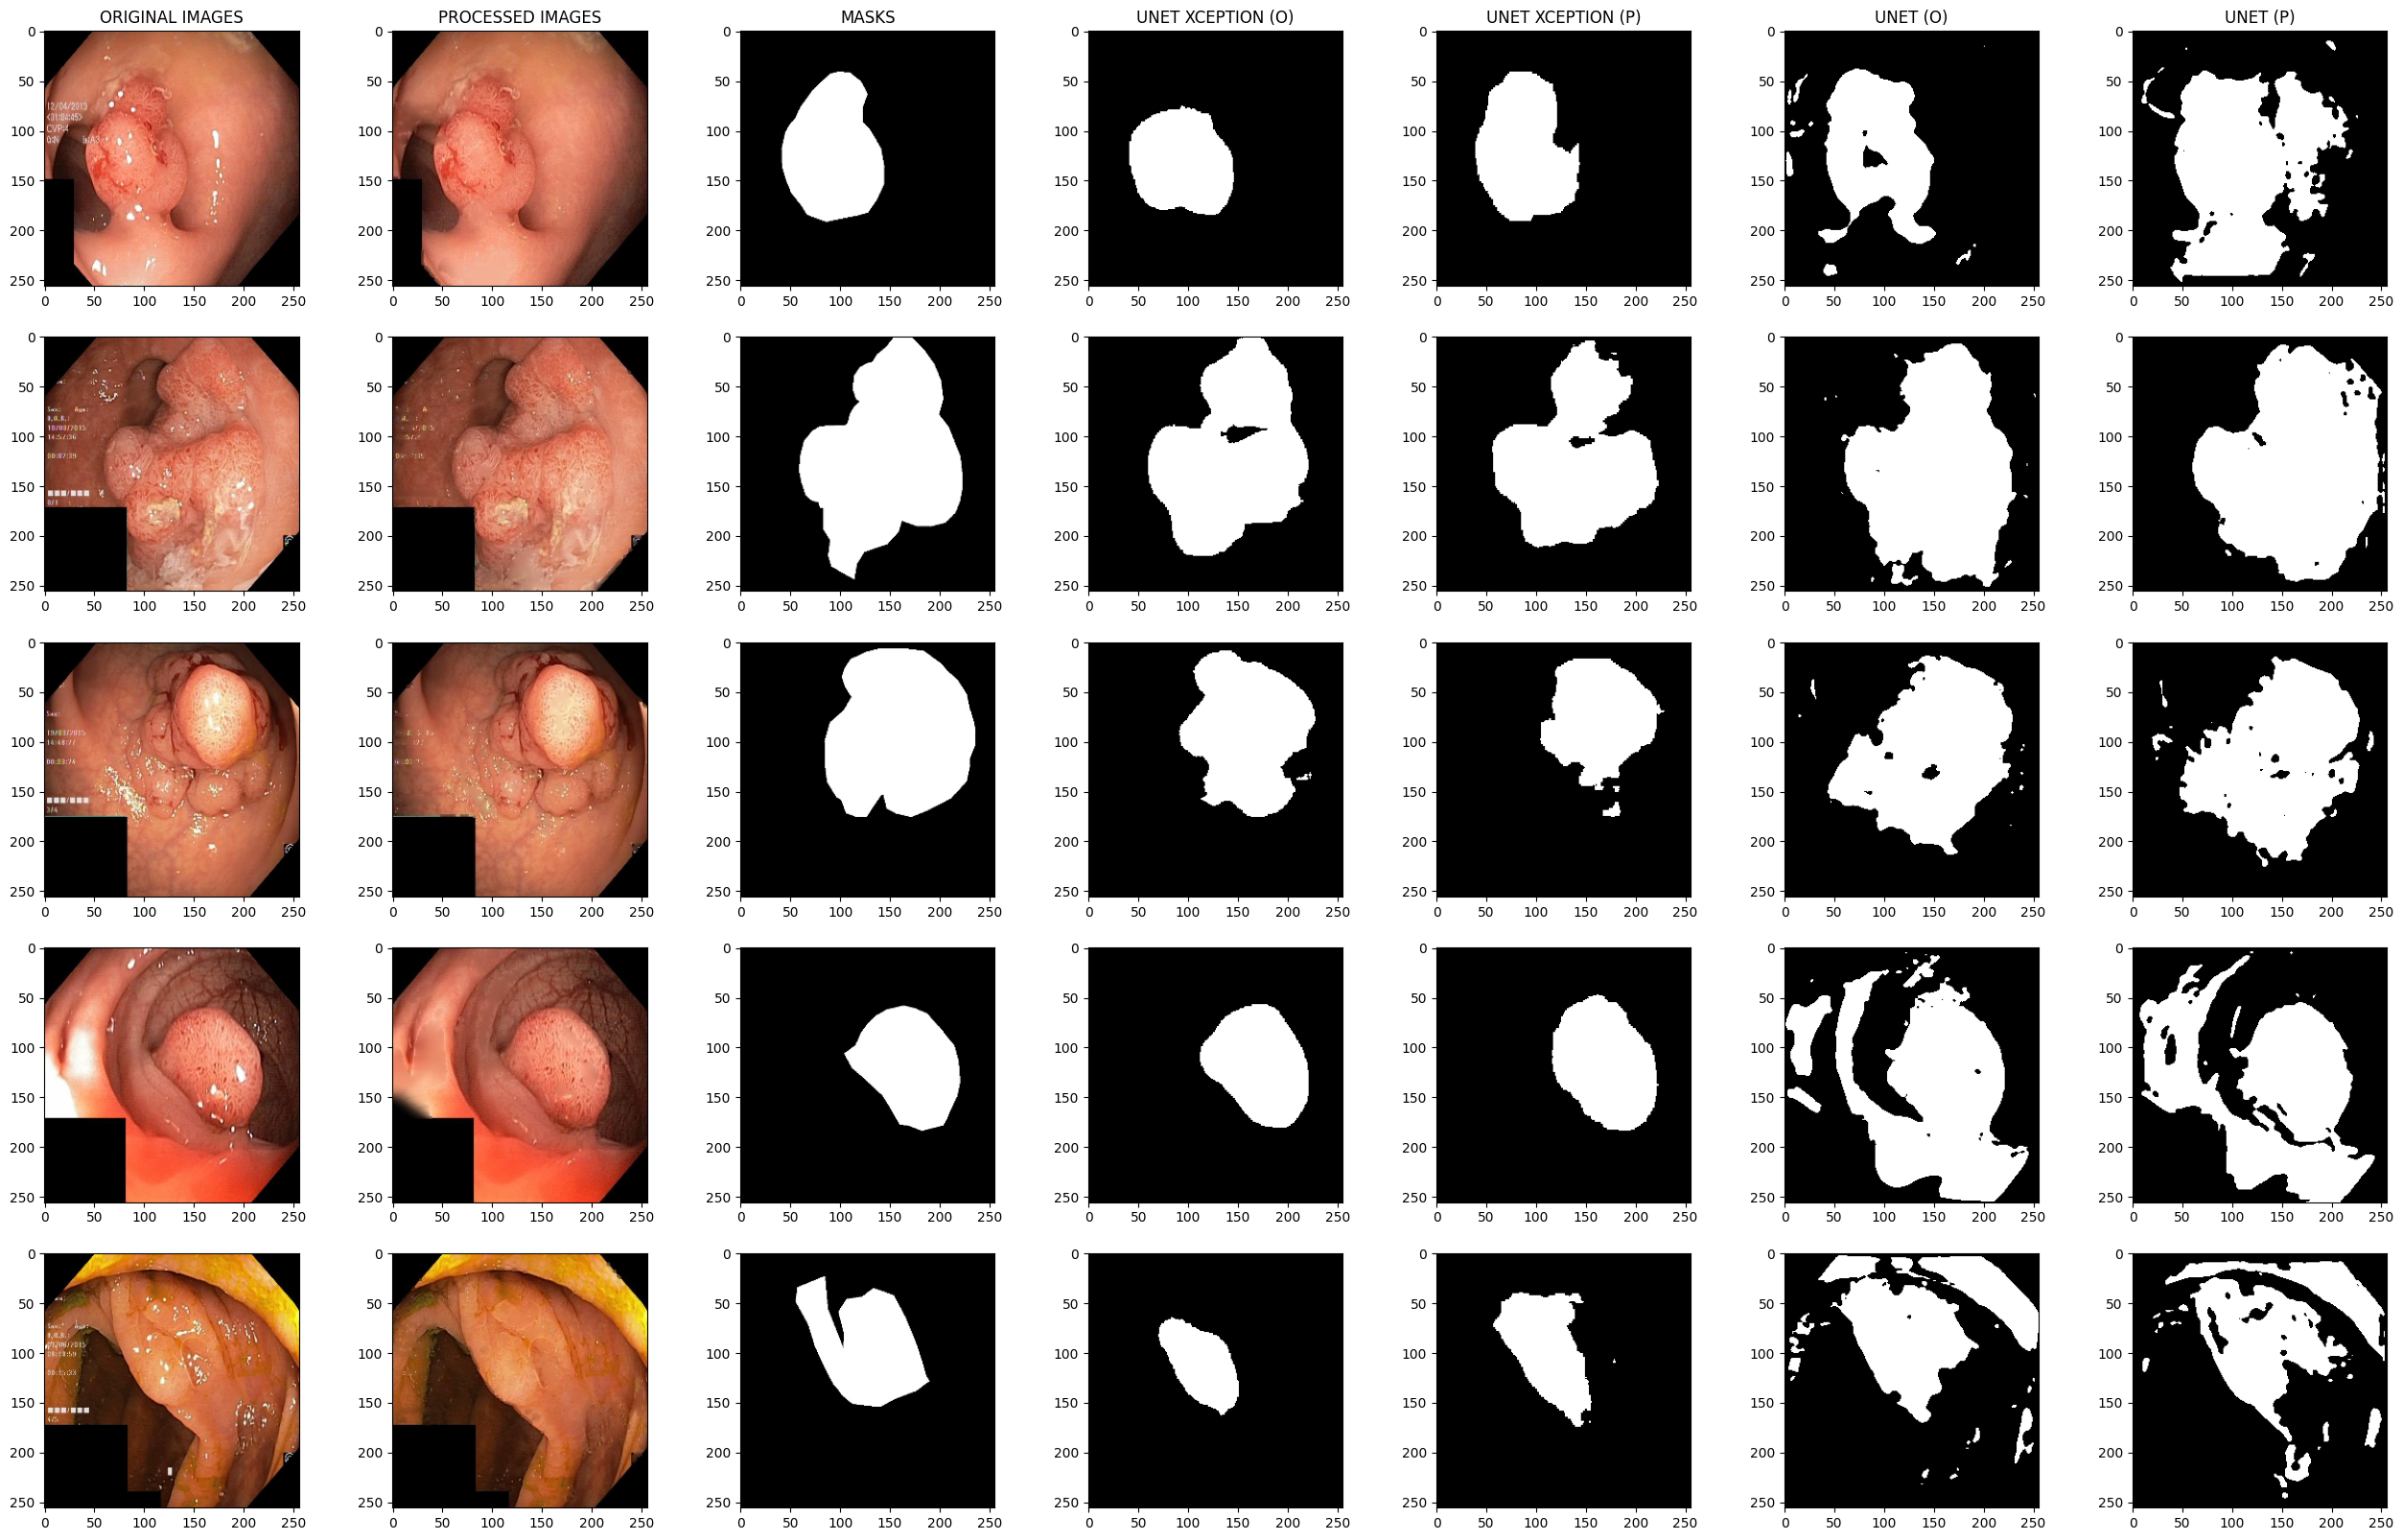

In [16]:
plot_mask1(check_ids)

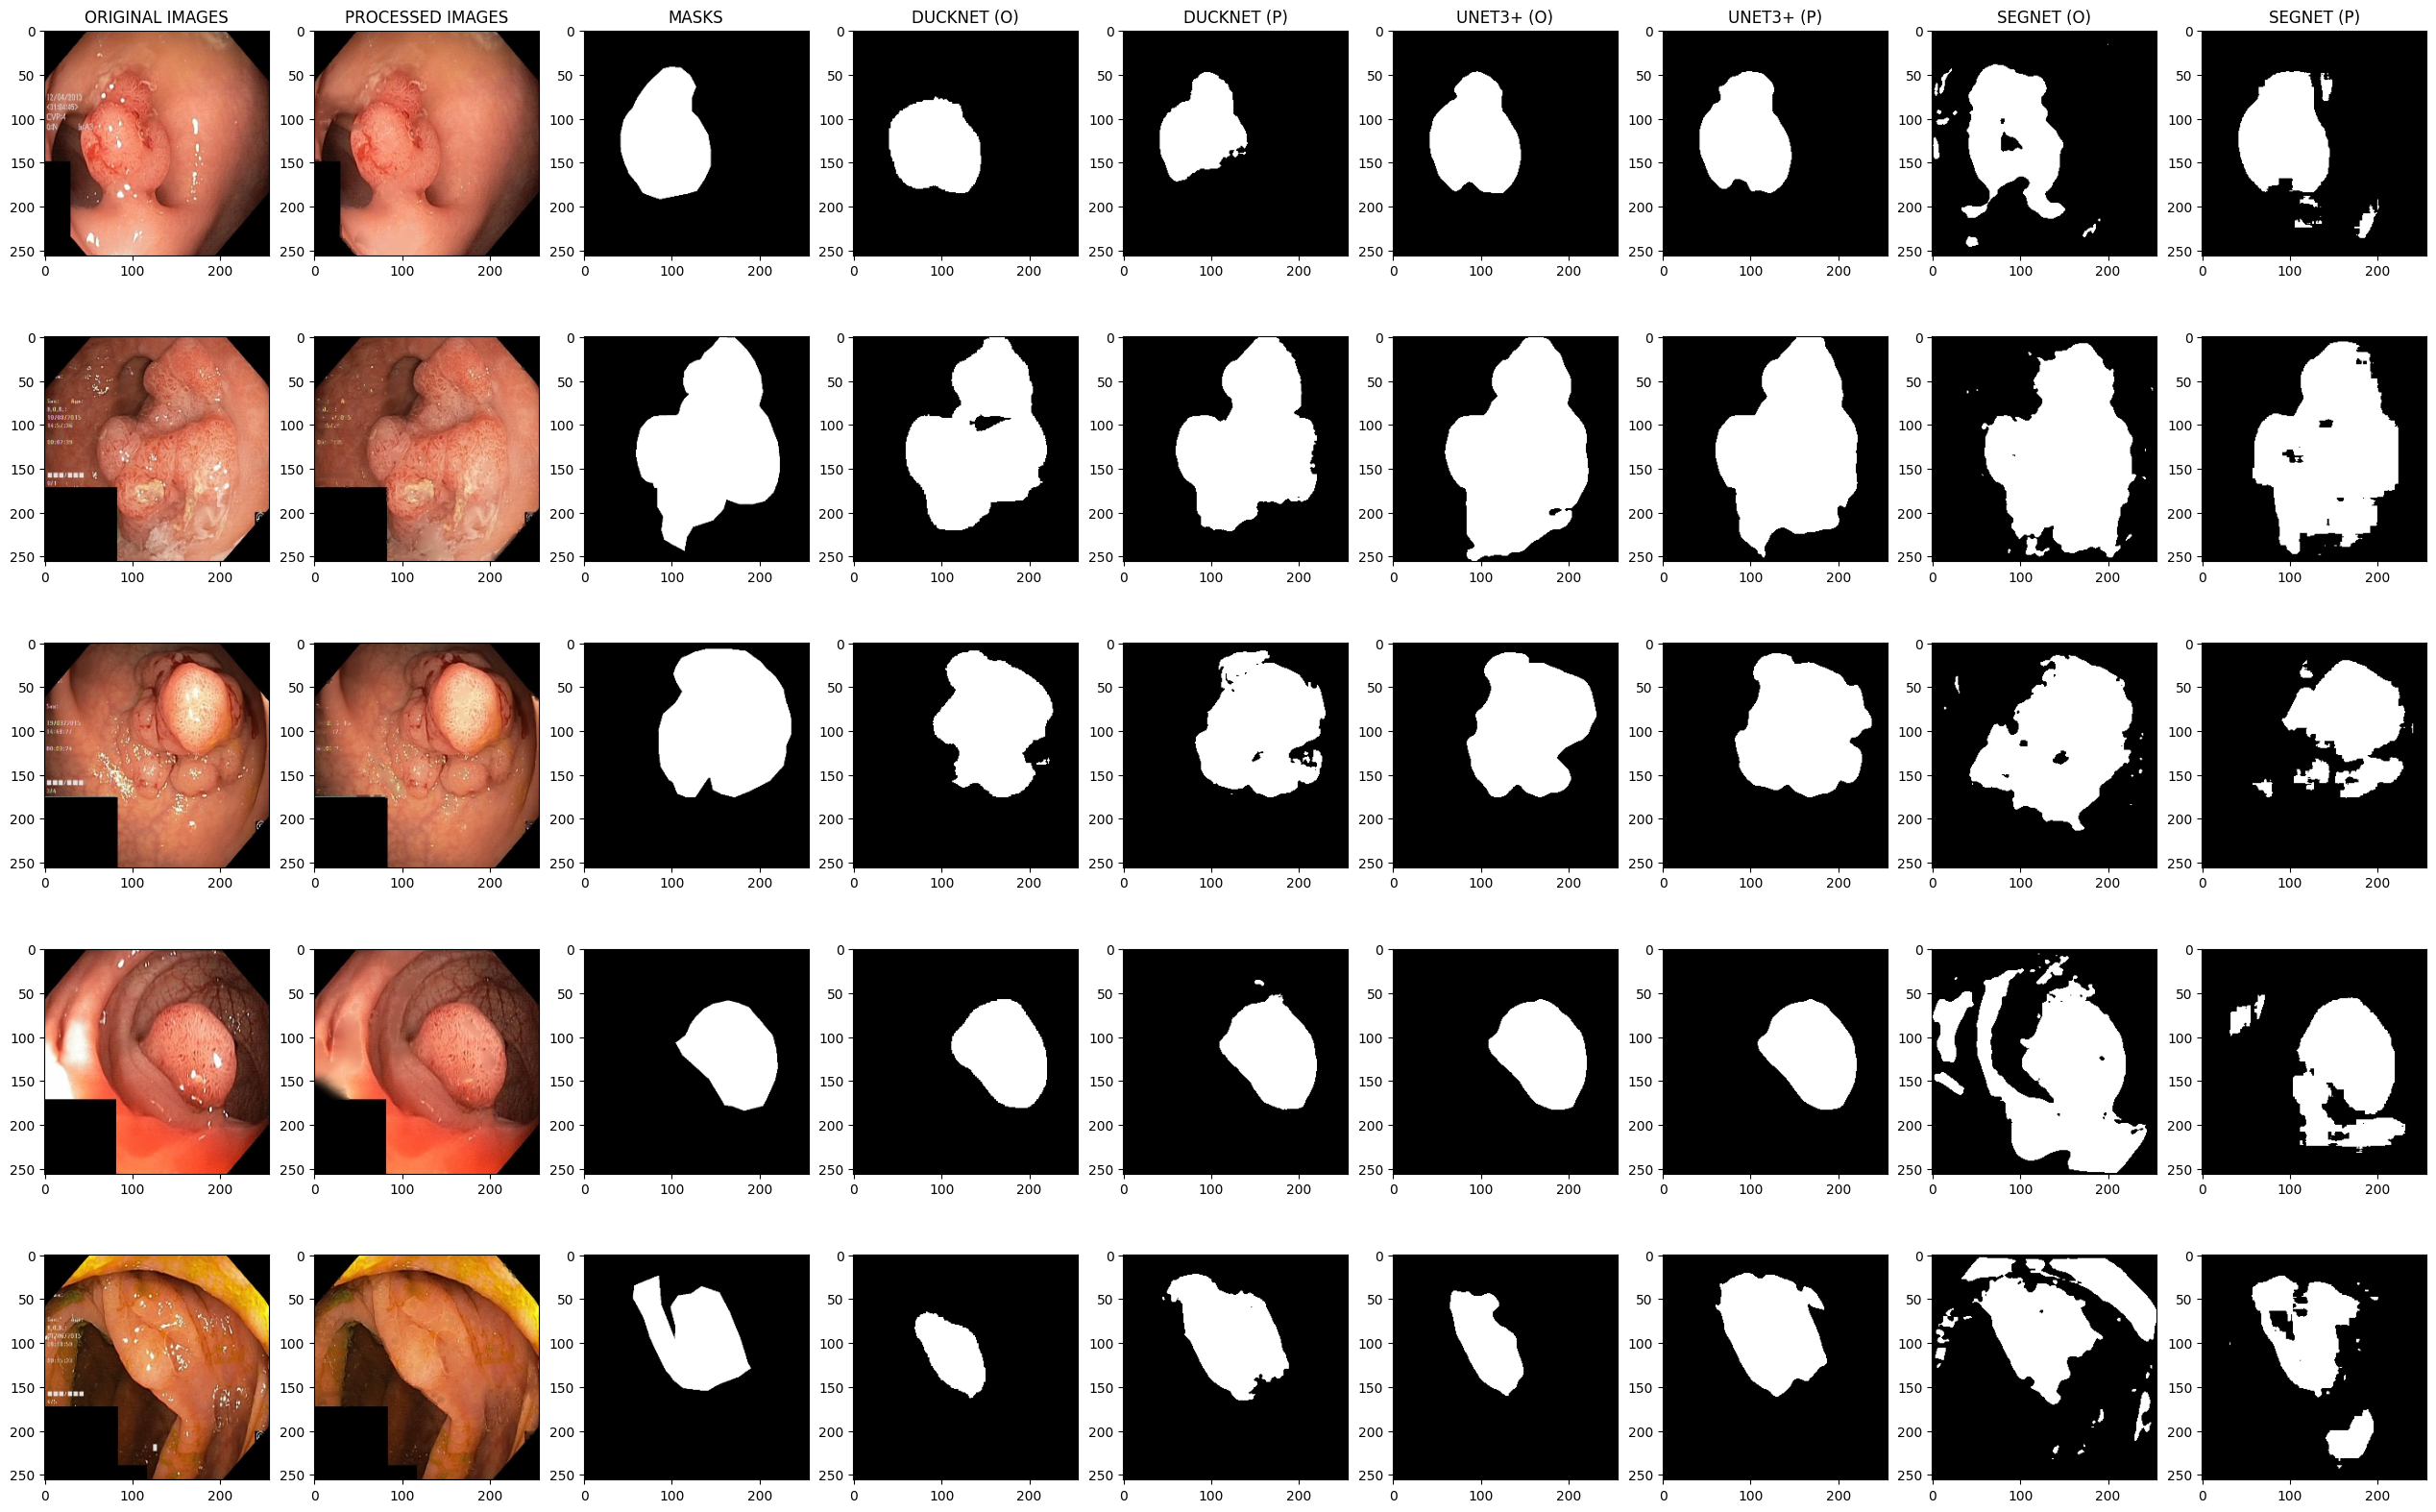

In [17]:
plot_mask2(check_ids)